In [2]:
try:
    # if this notebook is being called by another one
    # used passed gene_name value
    gene_name
except:
    # otherwise, set value to amacGFP / avGFP / cgreGFP / ppluGFP,
    # for instance for debugging here
    gene_name="avGFP"



In [3]:

def test_plot(y_true_,y_pred_):
    r2 = r2_score(y_true_, y_pred_)

    # Create scatter plot
    plt.figure(figsize=(10, 8))
    # plt.scatter(y_true_, y_pred_, color='blue', label='Data points')

    hb = plt.hexbin(y_true_, y_pred_, gridsize=50, cmap='coolwarm', bins='log')
    cb = plt.colorbar(hb)
    cb.set_label('log10(N)')


    #plot ideal 
    plt.plot([min(y_true_), max(y_true_)], [min(y_true_), max(y_true_)], color='red', linestyle='--', label='Ideal fit')
    plt.xlabel('Target')
    plt.ylabel('Predicted')
    plt.title('Scatter Plot of True vs. Predicted Values')
    plt.text(x=min(y_true_), y=max(y_pred_), s=f'\n\n    R² = {r2:.2f}', fontsize=15, verticalalignment='top')
    plt.legend()
    plt.grid(True)
    plt.show()

def history_plot(history):
    import matplotlib.pyplot as plt

    # Plot training & validation loss values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation MAE values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

def append_history(history, new_history):
    for key in history.history.keys():
        history.history[key].extend(new_history.history[key])

In [4]:
recompute=False
recompute_ESM=False
# True: retrain all models
# False: try loading saved models, otherwise retrain models

Import modules
Define functions
Load avGFP data
avGFP 239 aa


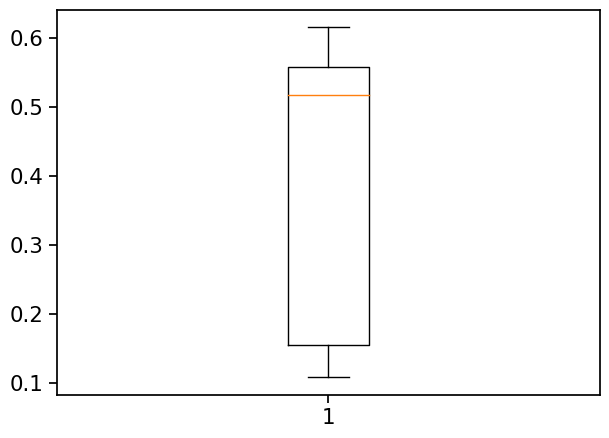

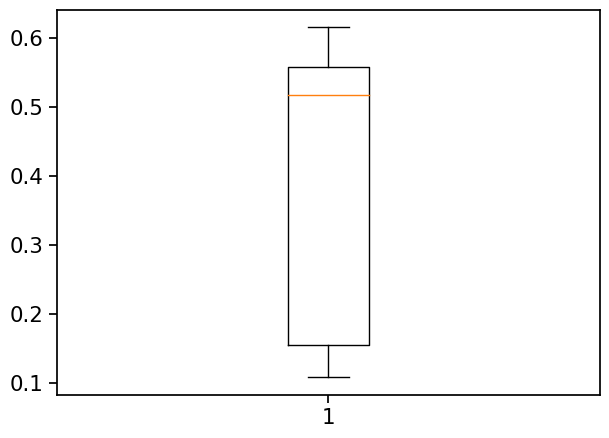

Pre-processing avGFP
Load avGFP encodings
Split train, valid, test sets
train_index 31029
valid_index 10343
test_index 10343


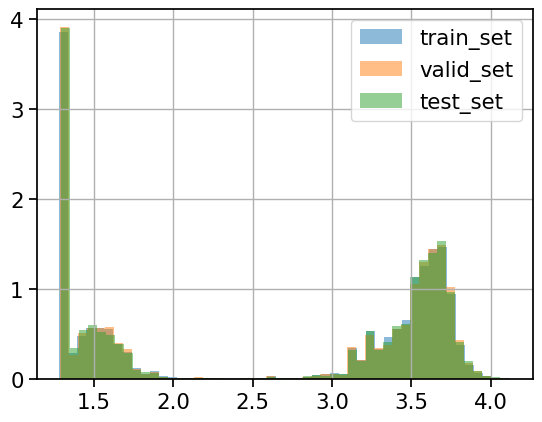

In [45]:
showmatrix=False
threshold_df = ''
%run 01_preprocessing.ipynb

In [46]:
df.sort_values('medianBrightness',ascending=+False)

,aaMutations,medianBrightness,aa_genotype_pseudo,full_seq
41469,T37S:K40R:N104S,4.123109,T40S:K43R:N108S,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDASYGRLTLKF...
21626,K106R:V162G:N211S,4.114503,K110R:V166G:N218S,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
22921,K157G,4.113576,K161G,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
51112,Y38N:T61A:Q156R,4.113576,Y41N:T64A:Q160R,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...
46675,V162A:S174R,4.107867,V166A:S178R,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
...,...,...,...,...
10326,F26S:E33G:H76R:F82Y:D179G,1.289624,F29S:E36G:H79R:F85Y:D183G,MSKGEELFTGVVPILVELDGDVNGHKSSVSGEGGGDATYGKLTLKF...
7050,E33V:L43P:K78E:I187L:T224S,1.289350,E36V:L46P:K81E:I191L:T232S,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGVGDATYGKLTPKF...
24633,K25E:E89G:T107A:I122T:L140R:M152V:Y236C,1.286571,K28E:E93G:T111A:I126T:L144R:M156V:Y244C,MSKGEELFTGVVPILVELDGDVNGHEFSVSGEGEGDATYGKLTLKF...
25021,K25M:L63P:F98L,1.285992,K28M:L66P:F102L,MSKGEELFTGVVPILVELDGDVNGHMFSVSGEGEGDATYGKLTLKF...


In [7]:
df

,aaMutations,medianBrightness,aa_genotype_pseudo,full_seq
0,wt,3.719212,wt,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
1,A109D,1.301030,A113D,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
2,A109D:N145D:I187V:M232T:L235P,1.301031,A113D:N149D:I191V:M240T:L243P,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
3,A109D:Y142N:H147L:E221G,1.301189,A113D:Y146N:H151L:E229G,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
4,A109G,3.708478,A113G,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
...,...,...,...,...
51710,Y91N:N104S:I170F,1.552090,Y95N:N108S:I174F,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
51711,Y91N:Q176L:L206Q:T229A:M232V,1.301030,Y95N:Q180L:L213Q:T237A:M240V,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
51712,Y91R:I151N:N197S,1.301030,Y95R:I155N:N204S,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
51713,Y91R:I166T:L235P,1.301517,Y95R:I170T:L243P,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...


In [8]:
# Count the occurrences of ':' in the 'aaMutations' column
df['count_colons'] = df['aaMutations'].apply(lambda x: x.count(':'))

# Count the number of rows for each count of ':'
colon_counts = df['count_colons'].value_counts().sort_index()
colon_counts

0      1085
1     12777
2     12336
3      9387
4      6825
5      4298
6      2526
7      1364
8       627
9       299
10      118
11       43
12       23
13        5
14        2
Name: count_colons, dtype: int64

In [9]:
 df['count_colons']

0        0
1        0
2        4
3        3
4        0
        ..
51710    2
51711    4
51712    2
51713    2
51714    4
Name: count_colons, Length: 51715, dtype: int64

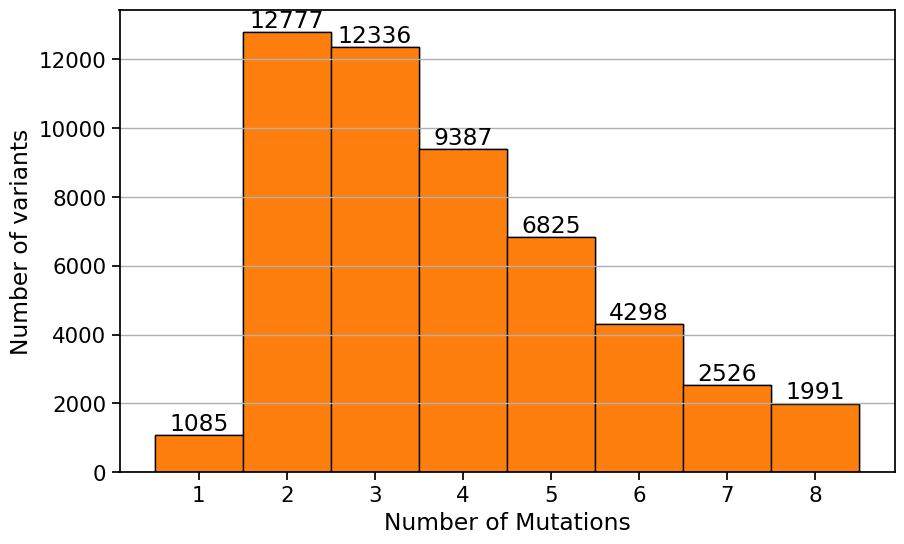

In [10]:
import matplotlib.pyplot as plt

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['count_colons'], bins=range(9), edgecolor='black', align='left')
plt.xlabel('Number of Mutations')
plt.ylabel('Number of variants')
plt.xticks(range(9))
plt.grid(axis='y')
plt.xticks(range(9), [f'{i+1}' for i in range(9)], rotation=0)
counts, bins, patches = plt.hist(df['count_colons'], bins=range(9), edgecolor='black', align='left')

# Add text on top of each bar
for count, patch in zip(counts, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height, f'{int(count)}', ha='center', va='bottom')



# Show the plot
plt.show()

In [11]:
_# create folder for saving figures and data of figures
try:mkdir("_transformers_Figures/")
except:pass

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K



In [44]:
df

,Unnamed: 0_x,aaMutations_x,full_seq,fitness_x,Unnamed: 0_y,aaMutations_y,medianBrightness,aa_genotype_pseudo,fitness_y,Fitness,color,category
0,0,Y38C,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATCGKLTLKF...,3.961320,52747.0,Y38C,3.769936,Y41C,3.961320,3.961320,#DC143C,0
1,1,Y38F,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATFGKLTLKF...,3.787285,52963.0,Y38F,3.731584,Y41F,3.787285,3.787285,#DC143C,0
2,2,Y38H,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATHGKLTLKF...,3.914370,53047.0,Y38H,3.763790,Y41H,3.914370,3.914370,#DC143C,0
3,3,Y38N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,3.964779,53247.0,Y38N,3.862983,Y41N,3.964779,3.964779,#DC143C,0
4,4,N104I,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.900431,34885.0,N104I,3.813328,N108I,3.900431,3.900431,#DC143C,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3494,3494,Y38N:N104Y:K157V:I170T:K213N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.141232,NaN,NaN,NaN,NaN,NaN,4.141232,#95a7ef,4
3495,3495,Y38N:N104Y:K157V:I170T:K213R,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.167542,NaN,NaN,NaN,NaN,NaN,4.167542,#95a7ef,4
3496,3496,Y38N:N104Y:K157V:I170V:K213E,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.230742,NaN,NaN,NaN,NaN,NaN,4.230742,#95a7ef,4
3497,3497,Y38N:N104Y:K157V:I170V:K213N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.179388,NaN,NaN,NaN,NaN,NaN,4.179388,#95a7ef,4


# using ESM embeddings

In [7]:
recompute_ESM=False
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# from preprocessing import *

from sklearn.svm import SVC, SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
# from src.kneighborRegressor import *
# from src.regression_grids import *

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [8]:
if recompute_ESM:
    # Function to load the ESM model
    def load_esm_model(model_name, device='cpu'):
        repr_layer = int(model_name.split('_')[1][1:])
        model, alphabet = torch.hub.load("facebookresearch/esm:main", model_name)
        batch_converter = alphabet.get_batch_converter()
        return model.eval().to(device), alphabet, batch_converter, repr_layer

    # Load the model
    model, alphabet, batch_converter, repr_layer = load_esm_model(model_name='esm2_t33_650M_UR50D', device='cpu')

    genes = df_["aaMutations"]
    device = "cpu"

    # Initialize an empty DataFrame to store predictors
    predictors = pd.DataFrame()

    for idx, gene in enumerate(genes):
        # Directly access the sequence associated with the gene
        sequence = df_.loc[df_["aaMutations"] == gene, "full_seq"].iloc[0][:-1]  # Remove final stop codon
        dt = [(gene, sequence)]
        batch_labels, batch_strs, batch_tokens = batch_converter(dt)
        
        with torch.no_grad():
            results_ = model(batch_tokens.to(device), repr_layers=[repr_layer], return_contacts=True)['representations'][repr_layer]
        
        # Compute features for this gene
        features = results_.mean(dim=1).cpu().numpy()  # Averages across the sequence_length dimension
        # features_2d = features.mean(axis=1)  # Further reduce to a single dimension per sample
        
        # Update predictors DataFrame for this gene
        gene_predictors = pd.DataFrame(features.reshape(1, -1), index=[gene])
        predictors = pd.concat([predictors, gene_predictors])
        
        # Save to CSV on each iteration (this updates the CSV file with new data)
        

        # # Optional print to monitor progress
        # if idx % 100 == 0:  # Print status every 100 genes processed
        #     print(f'Processed {idx+1} genes out of {len(genes)}')
    predictors.to_csv(r'D:\Bea\avGFP_ESMpredictors_total.csv')
    # Print final shape of predictors DataFrame
    print(predictors.shape)


In [ ]:

# df1= pd.read_csv(r'D:\Bea\avGFP_ESMpredictors.csv')
# df2 = pd.read_csv(r'D:\Bea\avGFP_ESMpredictors_2.csv')
# df3 = pd.concat([df1, df2])
# df3.reset_index(inplace=True, drop=True)
# df3.index = df3.iloc[:,0].values
# df3=df3.drop(columns='Unnamed: 0')
# df3.to_csv(r'D:\Bea\avGFP_ESMpredictors_total.csv')

In [25]:
predictors=pd.read_csv(r'D:\Bea\avGFP_ESMpredictors_total.csv')
predictors.reset_index(inplace=True, drop=True)
predictors.drop(columns='Unnamed: 0',inplace=True)

In [26]:
predictors

,aaMutations,0,1,2,3,4,5,6,7,8,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,wt,0.004420,-0.010806,-0.039352,-0.004249,-0.080919,-0.018824,-0.039308,0.020152,0.049724,...,0.146634,0.047349,0.014803,0.077491,-0.012645,0.109253,0.081489,0.014164,-0.013374,-0.009202
1,A109D,0.013414,0.005480,-0.024966,0.007041,-0.084338,-0.009175,-0.039329,0.009769,0.067250,...,0.145429,0.039966,0.014756,0.081403,-0.024934,0.104580,0.060403,0.008134,0.007964,-0.018587
2,A109D:N145D:I187V:M232T:L235P,-0.004498,-0.004762,-0.049193,-0.009528,-0.094472,-0.007792,-0.029339,0.011535,0.064937,...,0.165463,0.051789,0.012113,0.093974,-0.016039,0.118000,0.074705,-0.010761,0.002410,-0.020724
3,A109D:Y142N:H147L:E221G,0.013743,-0.003611,-0.027229,0.010028,-0.089830,-0.005264,-0.040026,0.018508,0.080657,...,0.145503,0.045153,0.018398,0.083854,-0.021423,0.105398,0.059490,0.002479,-0.010287,-0.010422
4,A109G,0.009904,-0.006905,-0.031065,-0.005074,-0.083564,-0.018463,-0.039464,0.011883,0.059924,...,0.144673,0.044404,0.014219,0.076938,-0.020277,0.108153,0.072625,0.016760,-0.005951,-0.009509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51710,Y91N:N104S:I170F,0.005575,-0.009617,-0.034236,-0.001236,-0.086473,-0.019616,-0.032684,0.020444,0.062518,...,0.145129,0.052969,0.015034,0.089065,-0.015429,0.100679,0.070732,0.017503,-0.011338,-0.009888
51711,Y91N:Q176L:L206Q:T229A:M232V,0.003160,-0.014020,-0.038566,-0.000342,-0.086004,-0.016294,-0.040385,0.016038,0.051165,...,0.147561,0.048063,0.013059,0.077378,-0.008303,0.090519,0.077944,0.012362,-0.017925,-0.000320
51712,Y91R:I151N:N197S,0.011072,-0.009971,-0.038365,-0.003960,-0.073947,-0.022506,-0.032816,0.012826,0.059133,...,0.150429,0.053323,0.017938,0.082343,-0.027753,0.106819,0.076847,0.012376,-0.005664,-0.010424
51713,Y91R:I166T:L235P,-0.008275,-0.010086,-0.051515,-0.021569,-0.091886,-0.028355,-0.030329,0.026899,0.064264,...,0.157627,0.057820,0.007733,0.093188,-0.005243,0.112241,0.086058,0.011568,-0.016701,-0.015416


In [27]:
target.reset_index(inplace=True,drop=True)

In [28]:
df.reset_index(inplace=True,drop=True)
df

,aaMutations,medianBrightness,aa_genotype_pseudo,full_seq
0,wt,3.719212,wt,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
1,A109D,1.301030,A113D,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
2,A109D:N145D:I187V:M232T:L235P,1.301031,A113D:N149D:I191V:M240T:L243P,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
3,A109D:Y142N:H147L:E221G,1.301189,A113D:Y146N:H151L:E229G,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
4,A109G,3.708478,A113G,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
...,...,...,...,...
51710,Y91N:N104S:I170F,1.552090,Y95N:N108S:I174F,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
51711,Y91N:Q176L:L206Q:T229A:M232V,1.301030,Y95N:Q180L:L213Q:T237A:M240V,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
51712,Y91R:I151N:N197S,1.301030,Y95R:I155N:N204S,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
51713,Y91R:I166T:L235P,1.301517,Y95R:I170T:L243P,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...


In [29]:
l2 = list(predictors['aaMutations'])
l1=list(df['aaMutations'])
for i in range(len(l2)):
    if l1[i]==l2[i]:
        pass
    else:
        print(i)
        print(l1[i], l2[i])
        
l1==l2
if l1==l2:
    predictors.drop(['aaMutations'],axis=1,inplace=True)

Split train, valid, test sets
train_index 31029
valid_index 10343
test_index 10343


<Axes: >

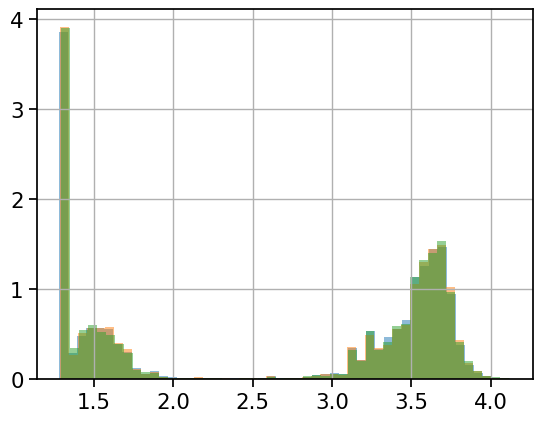

In [31]:
# First split train, valid, test indexes (not very elegant, yes)
print("Split train, valid, test sets")

(predictors_train,
predictors_valid_test, 
target_train, 
target_valid_test) = train_test_split(df.index, 
                                    df.index, 
                                    test_size=0.4, 
                                    random_state=42)

(predictors_valid, 
predictors_test, 
target_valid,
target_test) = train_test_split(predictors_valid_test, 
                            target_valid_test, 
                            test_size=0.5, 
                            random_state=42)

train_index = sorted(predictors_train)
valid_index = sorted(predictors_valid)
test_index  = sorted(predictors_test)

    
predictors_train = predictors.loc[train_index]
predictors_valid = predictors.loc[valid_index]
predictors_test = predictors.loc[test_index]

target_train = target.loc[train_index]
target_valid = target.loc[valid_index]
target_test = target.loc[test_index]

print("train_index",len(train_index))
print("valid_index",len(valid_index))
print("test_index",len(test_index))

#------------------------------------------------------------
# check subset sizes and medianBrightness distributions (using density parameter)
fig, ax = plt.subplots()
fig.patch.set_facecolor('w')

target_train[brightness_col].hist(alpha=0.5, density=True, bins=50)
target_valid[brightness_col].hist(alpha=0.5, density=True, bins=50)
target_test[brightness_col].hist(alpha=0.5, density=True, bins=50)


In [49]:
def build_model(embedding_dim, num_labels):
    # Input layer that accepts embeddings directly
    input_layer = Input(shape=(embedding_dim,))

    # Adding a few dense layers for processing
    x = Dense(512, activation='relu')(input_layer)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Prediction layer
    output_layer = Dense(num_labels, activation='linear')(x)  # Use sigmoid for binary classification/regression

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model


In [53]:
del model
K.clear_session()  
# Define model parameters
embedding_dim = len(predictors_train.columns)  # Example embedding dimension
num_labels = 1       # Number of output labels; change as needed

# Create the model
model = build_model(embedding_dim, num_labels)

# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',  # Use 'categorical_crossentropy' for multi-label classification
              metrics=['mean_absolute_error'])


In [54]:
# Train the model
history = model.fit(predictors_train.values, 
          target_train.values.ravel(), 
          epochs=100, 
          batch_size=32, 
          validation_data=(predictors_valid.values, target_valid.values.ravel()))


Epoch 1/100
970/970 [==============================] - 4s 4ms/step - loss: 1.1060 - mean_absolute_error: 0.9001 - val_loss: 0.8230 - val_mean_absolute_error: 0.8270
Epoch 2/100
970/970 [==============================] - 3s 4ms/step - loss: 0.9457 - mean_absolute_error: 0.8526 - val_loss: 0.8602 - val_mean_absolute_error: 0.8710
Epoch 3/100
970/970 [==============================] - 3s 4ms/step - loss: 0.9930 - mean_absolute_error: 0.9050 - val_loss: 0.9026 - val_mean_absolute_error: 0.9150
Epoch 4/100
970/970 [==============================] - 3s 4ms/step - loss: 0.9477 - mean_absolute_error: 0.8693 - val_loss: 0.8385 - val_mean_absolute_error: 0.8548
Epoch 5/100
970/970 [==============================] - 3s 4ms/step - loss: 0.9709 - mean_absolute_error: 0.8888 - val_loss: 0.7970 - val_mean_absolute_error: 0.8425
Epoch 6/100
970/970 [==============================] - 3s 4ms/step - loss: 0.9592 - mean_absolute_error: 0.8763 - val_loss: 0.7717 - val_mean_absolute_error: 0.7975
Epoch 7/10

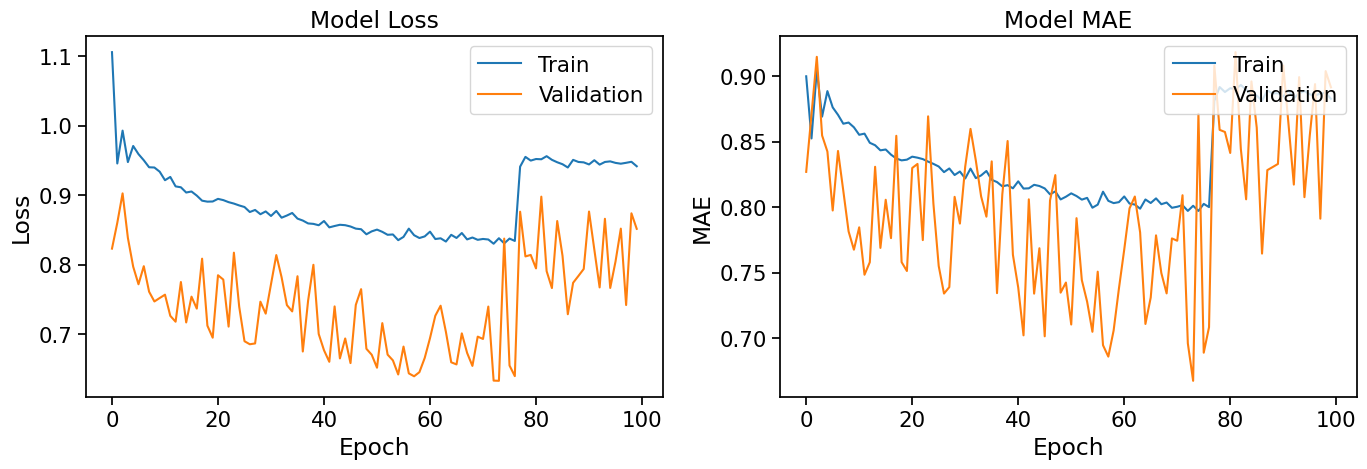

In [55]:
history_plot(history)

In [56]:

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(predictors_test.values, target_test.values.ravel())
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
y_pred=model.predict(predictors_test)


324/324 [==============================] - 1s 2ms/step - loss: 0.8518 - mean_absolute_error: 0.8912
Test Loss: 0.8518098592758179
Test Accuracy: 0.8911632895469666
324/324 [==============================] - 0s 1ms/step


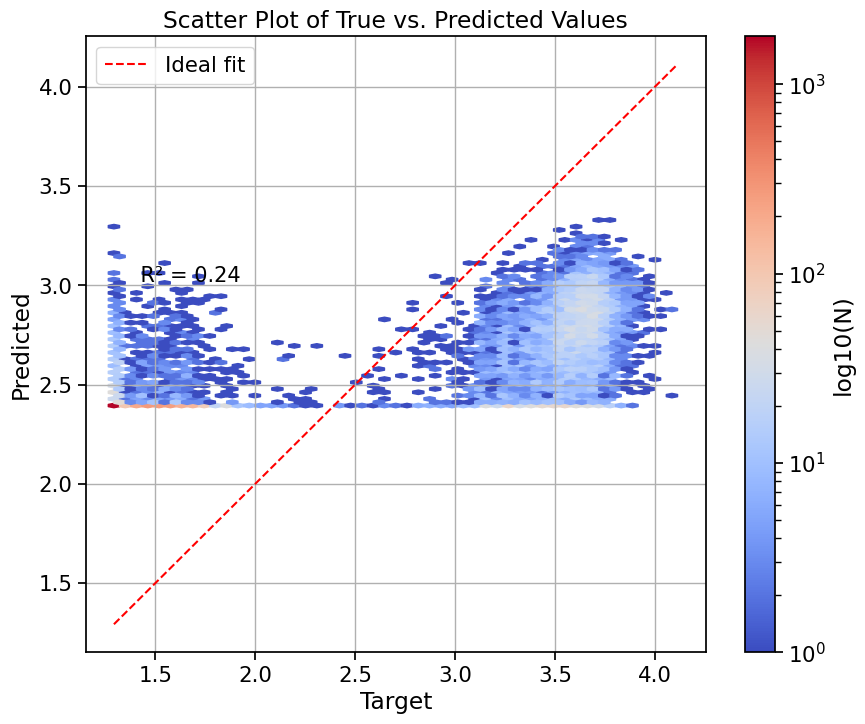

In [57]:
y_pred_ = y_pred.ravel()
y_true_ = target_test.values.ravel()


test_plot(y_true_,y_pred_)

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

## ARCH 4
def build_model(input_length):
    model = Sequential([
        # Convolutional Layer
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(input_length, 1)),
        MaxPooling1D(pool_size=2),
        # Additional Convolutional Layers
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        # Flatten the output of the conv layers to feed into dense layer
        Flatten(),
        # Dense Layer for prediction
        Dense(128, activation='relu'),
        # Output layer for regression
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model


In [61]:
import numpy as np
del model
K.clear_session()  
input_length = len(predictors_train.values[0])
# Example of using the model
model = build_model(input_length)  
# Train the model
history = model.fit(predictors_train.values, 
          target_train.values.ravel(), 
          epochs=100, 
          batch_size=32, 
          validation_data=(predictors_valid.values, target_valid.values.ravel()))

Epoch 1/100
970/970 [==============================] - 9s 7ms/step - loss: 0.8924 - mean_absolute_error: 0.8274 - val_loss: 0.6914 - val_mean_absolute_error: 0.6879
Epoch 2/100
970/970 [==============================] - 7s 7ms/step - loss: 0.7086 - mean_absolute_error: 0.6960 - val_loss: 0.7728 - val_mean_absolute_error: 0.6536
Epoch 3/100
970/970 [==============================] - 7s 7ms/step - loss: 0.6570 - mean_absolute_error: 0.6582 - val_loss: 0.6875 - val_mean_absolute_error: 0.6129
Epoch 4/100
970/970 [==============================] - 7s 7ms/step - loss: 0.6212 - mean_absolute_error: 0.6300 - val_loss: 0.5664 - val_mean_absolute_error: 0.5933
Epoch 5/100
970/970 [==============================] - 7s 7ms/step - loss: 0.5880 - mean_absolute_error: 0.6055 - val_loss: 0.6199 - val_mean_absolute_error: 0.6601
Epoch 6/100
970/970 [==============================] - 6s 7ms/step - loss: 0.5701 - mean_absolute_error: 0.5919 - val_loss: 0.5346 - val_mean_absolute_error: 0.5801
Epoch 7/10

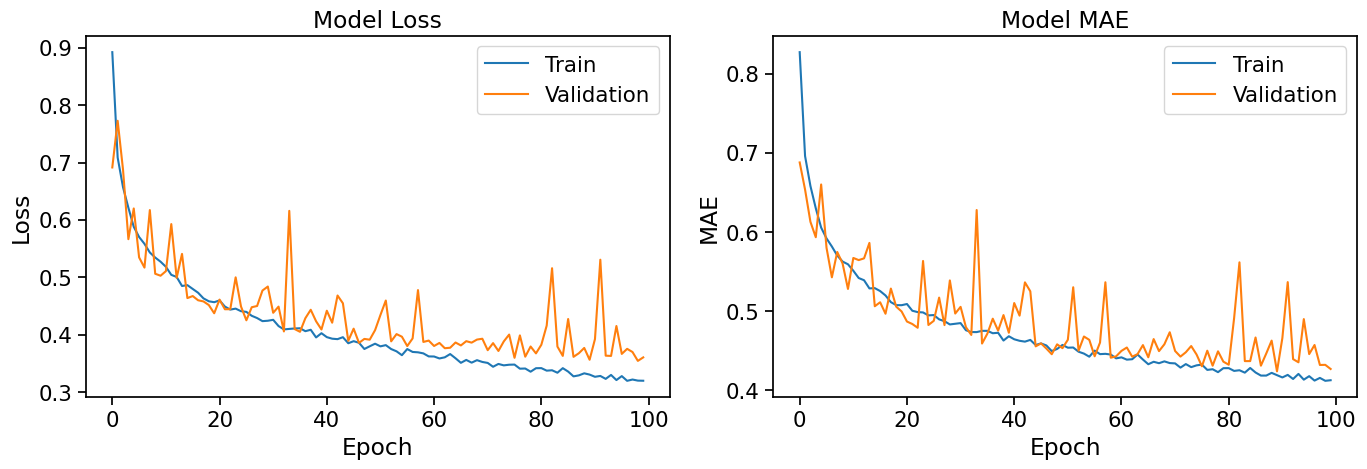

In [62]:
history_plot(history)

In [70]:
new_history = model.fit(predictors_train.values, 
                        target_train.values.ravel(), 
                        epochs=50,  # Additional epochs
                        batch_size=32,
                        validation_data=(predictors_valid.values, 
                                         target_valid.values.ravel()))
append_history(history, new_history)

Epoch 1/50
970/970 [==============================] - 7s 7ms/step - loss: 0.3152 - mean_absolute_error: 0.4099 - val_loss: 0.3634 - val_mean_absolute_error: 0.4269
Epoch 2/50
970/970 [==============================] - 7s 7ms/step - loss: 0.3214 - mean_absolute_error: 0.4143 - val_loss: 0.4236 - val_mean_absolute_error: 0.4645
Epoch 3/50
970/970 [==============================] - 6s 7ms/step - loss: 0.3098 - mean_absolute_error: 0.4052 - val_loss: 0.4156 - val_mean_absolute_error: 0.4945
Epoch 4/50
970/970 [==============================] - 7s 7ms/step - loss: 0.3147 - mean_absolute_error: 0.4090 - val_loss: 0.3568 - val_mean_absolute_error: 0.4291
Epoch 5/50
970/970 [==============================] - 7s 7ms/step - loss: 0.3115 - mean_absolute_error: 0.4077 - val_loss: 0.3655 - val_mean_absolute_error: 0.4303
Epoch 6/50
970/970 [==============================] - 7s 7ms/step - loss: 0.3103 - mean_absolute_error: 0.4067 - val_loss: 0.3552 - val_mean_absolute_error: 0.4323
Epoch 7/50
970/9

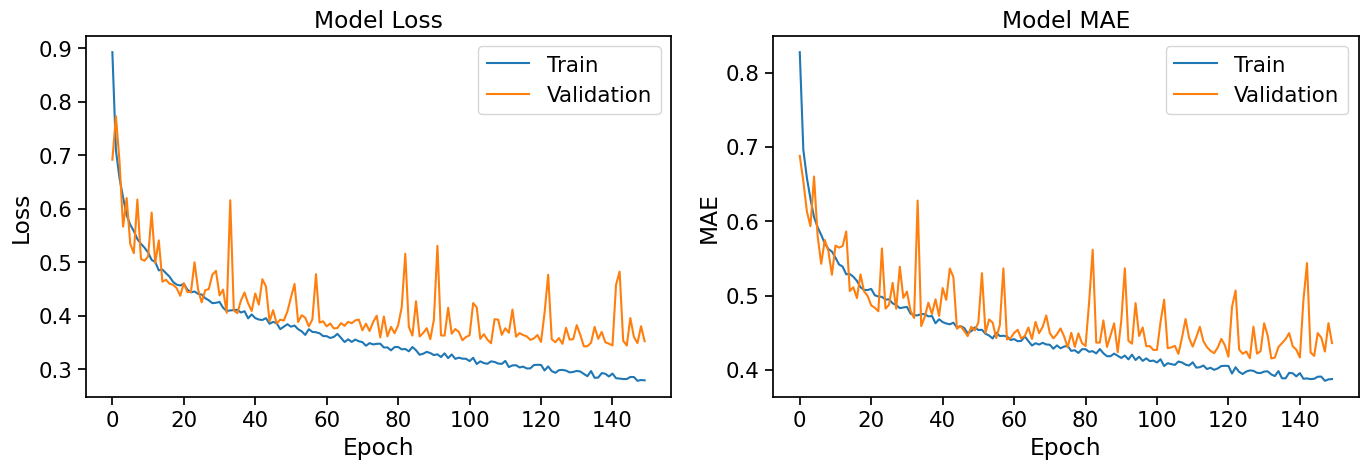

In [71]:
history_plot(history)

In [72]:

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(predictors_test.values, target_test.values.ravel())
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
y_pred=model.predict(predictors_test.values)


324/324 [==============================] - 1s 3ms/step - loss: 0.3549 - mean_absolute_error: 0.4331
Test Loss: 0.35491907596588135
Test Accuracy: 0.43313536047935486
324/324 [==============================] - 1s 2ms/step


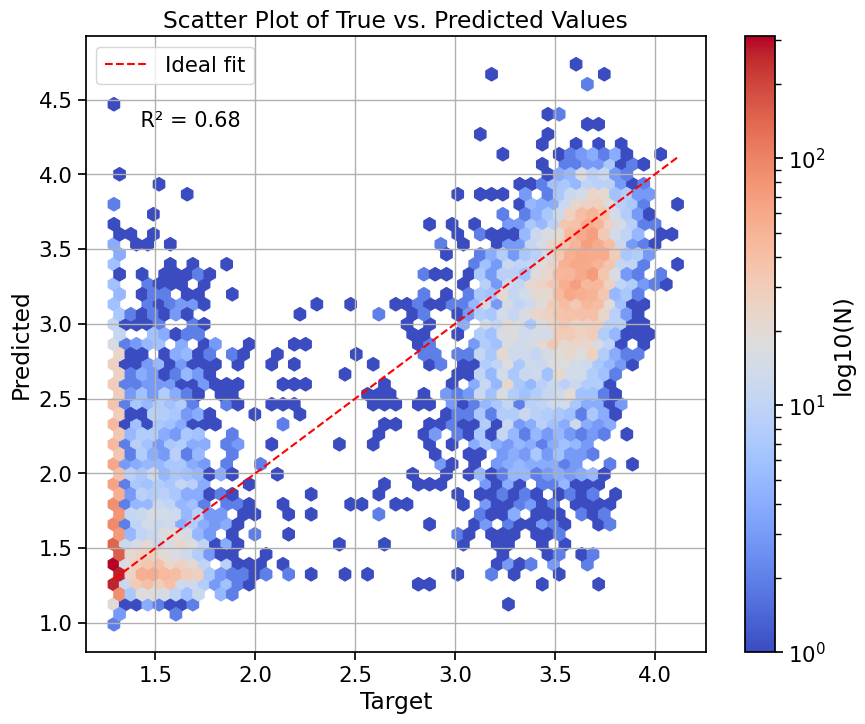

In [73]:

y_pred_ = y_pred.ravel()
y_true_ = target_test.values.ravel()
test_plot(y_true_,y_pred_)

# using one-hot encoding 

In [ ]:
X_train_flat = predictors_train.values
# Reshape the flat array to (238, 20) per sample
num_samples = X_train_flat.shape[0]
X_train = X_train_flat.reshape(num_samples, 239, 20)

y_train = target_train.values.ravel()


#test re shape
X_test_flat = predictors_test.values
# Reshape the flat array to (238, 20) per sample
num_samples = X_test_flat.shape[0]
X_test = X_test_flat.reshape(num_samples, 239, 20)

y_test = target_test.values.ravel()

#valid re shape
X_val_flat = predictors_valid.values
# Reshape the flat array to (238, 20) per sample
num_samples = X_val_flat.shape[0]
X_val = X_val_flat.reshape(num_samples, 239, 20)

y_val = target_valid.values.ravel()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

##ARCH 1
def build_model(input_shape):
    model = Sequential([
        # Convolutional Layer
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        # You can add more convolutional and pooling layers here
        Flatten(),
        # Dense Layer for prediction
        Dense(128, activation='relu'),
        Dropout(0.5),  # Dropout added to prevent overfitting
        # Output layer for regression
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model


In [ ]:
### ARCH 2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def build_model(input_shape):
    model = Sequential([
        # First Convolutional Layer
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        
        # Second Convolutional Layer
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        
      
        # Flatten the output of the conv layers to feed into dense layer
        Flatten(),
        
        # Dense Layer for prediction with Dropout for regularization
        Dense(128, activation='relu'),
        Dropout(0.5),  # Dropout added to prevent overfitting
        
        # Output layer for regression
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model


In [ ]:
##ARCH 4
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def build_model(input_shape):
    model = Sequential([
        # First Convolutional Layer
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        
        # Second Convolutional Layer
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        
        # Flatten the output of the conv layers to feed into dense layer
        Flatten(),
        
        # First Dense Layer for prediction
        Dense(128, activation='relu'),
        
        # Additional Dense Layers
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),  # Another dense layer to increase complexity
        
        # Dropout for regularization
        Dropout(0.5),
        
        # Output layer for regression
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model


In [ ]:
# Parameters
input_shape = (239, 20)  # Length of sequence by number of amino acids

# Build the model
model = build_model(input_shape)
# Train the model
history = model.fit(X_train, y_train, 
                epochs=100, 
                batch_size=32, 
                validation_data=(X_val, y_val))


In [ ]:
model.summary()

In [ ]:
history_plot(history)


In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

y_test_pred = model.predict(X_test)

In [ ]:
def get_indices_gt_thr(lst, thr):
    return [i for i, x in enumerate(lst) if x > thr]
def filter_by_indices(data, indices):
    return [data[i] for i in indices if i < len(data)]

In [ ]:
index = get_indices_gt_thr(y_true_, 2.5)

y_true_ = np.array(filter_by_indices(y_true_, index))
y_pred_ = np.array(filter_by_indices(y_pred_, index))


In [ ]:
y_pred_ = y_test_pred.ravel()
y_true_ = y_test
# Calculate R-squared value
test_plot(y_true_,y_pred_)

# using BLOSUM encoding 

In [14]:
blosum = pd.read_csv('BLOSUM.csv')
blosum.set_index('AA', inplace=True, drop=True)

In [15]:
amino_acid_vectors = blosum.to_numpy()
amino_acid_index = {aa: i for i, aa in enumerate(blosum.index)}

In [16]:
def sequence_to_blosum(sequences, amino_acid_index, amino_acid_vectors):
    n = len(sequences)
    m = max(len(seq) for seq in sequences)
    p = amino_acid_vectors.shape[1]

    # Pre-allocate the numpy array
    matrix = np.zeros((n, m, p), dtype=np.float32)

    for i, seq in enumerate(sequences):
        # Convert sequence to indices, handling missing values with -1
        indices = np.array([amino_acid_index.get(aa, -1) for aa in seq], dtype=int)

        # Filter valid indices
        valid_indices = indices != -1

        # Fetch vectors for valid indices
        if np.any(valid_indices):
            matrix[i, valid_indices] = amino_acid_vectors[indices[valid_indices]]

    return matrix

In [20]:
sequences

array(['MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*',
       'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRDEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*',
       'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRDEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYDSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPVGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGTDEPYK*',
       ...,
       'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGRVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYNMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDSHYLSTQSALSKDPNEKRDHMVLLEFVTAAGIT

In [17]:
sequences = df['full_seq'].values
blosum_encoded = sequence_to_blosum(sequences,amino_acid_index, amino_acid_vectors)

In [18]:
X_train = blosum_encoded[train_index]
X_val = blosum_encoded[valid_index]
X_test = blosum_encoded[test_index]

y_train = target_train.values.ravel()
y_val = target_valid.values.ravel()
y_test = target_test.values.ravel()


In [64]:
### ARCH 5
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def build_model(input_shape):
    model = Sequential([
        # First Convolutional Layer
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        
        # Second Convolutional Layer
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        
        # Optionally add more layers...
        
        # Flatten the output of the conv layers to feed into dense layer
        Flatten(),
        
        # Dense Layer for prediction with Dropout for regularization
        Dense(128, activation='relu'),
        Dropout(0.5),  # Dropout added to prevent overfitting
        
        # Output layer for regression
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model


In [ ]:
### ARCH 6
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

def build_model(input_shape):
    model = Sequential([
        # First Convolutional Layer
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        
        # Second Convolutional Layer
        Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        
        # Optionally add more layers...
        
        # Flatten the output of the conv layers to feed into dense layer
        Flatten(),
        
        # Additional Dense Layer
        Dense(128, activation='relu'),
        Dropout(0.5),  # Slightly less dropout for this layer

        # Another Additional Dense Layer
        Dense(64, activation='relu'),
        Dropout(0.5),  # Slightly less dropout for this layer
        # Output layer for regression
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model


In [65]:
# Parameters
input_shape = (239, 20)  # Length of sequence by number of amino acids

# Build the model
model = build_model(input_shape)
# Train the model
history = model.fit(X_train, y_train, 
                epochs=100, 
                batch_size=32, 
                validation_data=(X_val, y_val))


Epoch 1/100
970/970 [==============================] - 6s 5ms/step - loss: 0.9519 - mean_absolute_error: 0.8238 - val_loss: 0.4014 - val_mean_absolute_error: 0.5491
Epoch 2/100
970/970 [==============================] - 5s 5ms/step - loss: 0.4706 - mean_absolute_error: 0.5411 - val_loss: 0.2377 - val_mean_absolute_error: 0.3365
Epoch 3/100
970/970 [==============================] - 5s 5ms/step - loss: 0.3444 - mean_absolute_error: 0.4529 - val_loss: 0.1820 - val_mean_absolute_error: 0.2877
Epoch 4/100
970/970 [==============================] - 5s 5ms/step - loss: 0.2982 - mean_absolute_error: 0.4164 - val_loss: 0.1769 - val_mean_absolute_error: 0.2853
Epoch 5/100
970/970 [==============================] - 5s 5ms/step - loss: 0.2596 - mean_absolute_error: 0.3859 - val_loss: 0.1498 - val_mean_absolute_error: 0.2619
Epoch 6/100
970/970 [==============================] - 5s 5ms/step - loss: 0.2308 - mean_absolute_error: 0.3607 - val_loss: 0.1319 - val_mean_absolute_error: 0.2527
Epoch 7/10

In [70]:

# Save the entire model
model.save('BLOSUM_arch5.h5')


In [19]:

# Load the model
model = tf.keras.models.load_model('BLOSUM_arch5.h5')

In [71]:
new_history = model.fit(X_train, y_train, 
                        epochs=50,  # Additional epochs
                        batch_size=32,
                        validation_data=(X_val, y_val))
append_history(history, new_history)

Epoch 1/50
970/970 [==============================] - 5s 5ms/step - loss: 0.1229 - mean_absolute_error: 0.2708 - val_loss: 0.1012 - val_mean_absolute_error: 0.2173
Epoch 2/50
970/970 [==============================] - 5s 5ms/step - loss: 0.1219 - mean_absolute_error: 0.2694 - val_loss: 0.1013 - val_mean_absolute_error: 0.2229
Epoch 3/50
970/970 [==============================] - 5s 5ms/step - loss: 0.1221 - mean_absolute_error: 0.2698 - val_loss: 0.1009 - val_mean_absolute_error: 0.2170
Epoch 4/50
970/970 [==============================] - 5s 5ms/step - loss: 0.1217 - mean_absolute_error: 0.2693 - val_loss: 0.1025 - val_mean_absolute_error: 0.2244
Epoch 5/50
970/970 [==============================] - 5s 5ms/step - loss: 0.1217 - mean_absolute_error: 0.2697 - val_loss: 0.1045 - val_mean_absolute_error: 0.2170
Epoch 6/50
970/970 [==============================] - 5s 5ms/step - loss: 0.1229 - mean_absolute_error: 0.2710 - val_loss: 0.0993 - val_mean_absolute_error: 0.2158
Epoch 7/50
970/9

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 239, 32)           1952      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 119, 32)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 119, 64)           6208      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 59, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3776)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

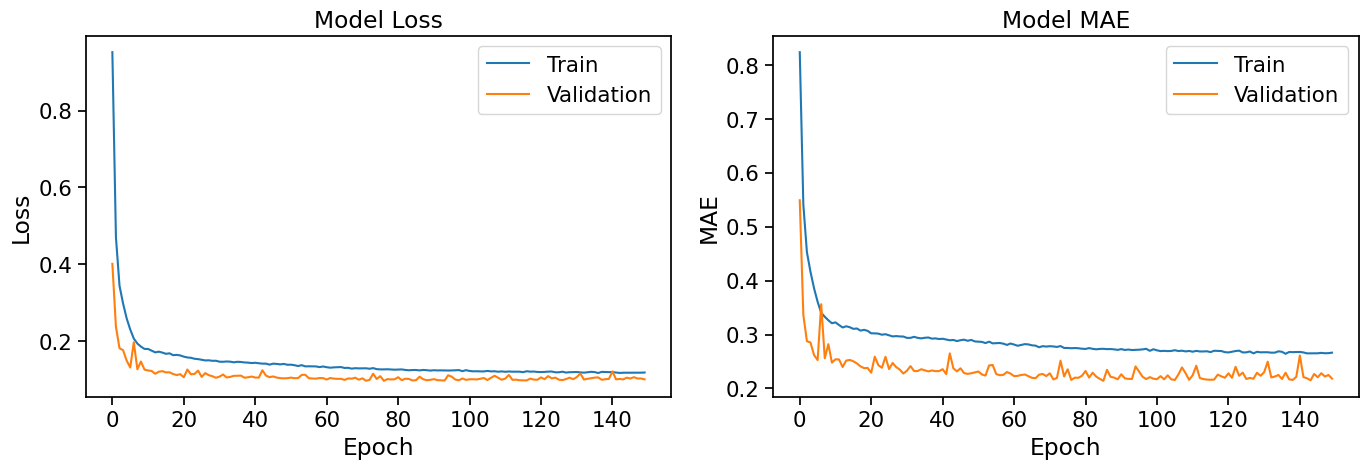

In [81]:
history_plot(history)

In [21]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

y_test_pred = model.predict(X_test)

324/324 [==============================] - 5s 3ms/step - loss: 0.1045 - mean_absolute_error: 0.2265
Test Loss: 0.10447218269109726
Test Accuracy: 0.22652770578861237
324/324 [==============================] - 1s 2ms/step


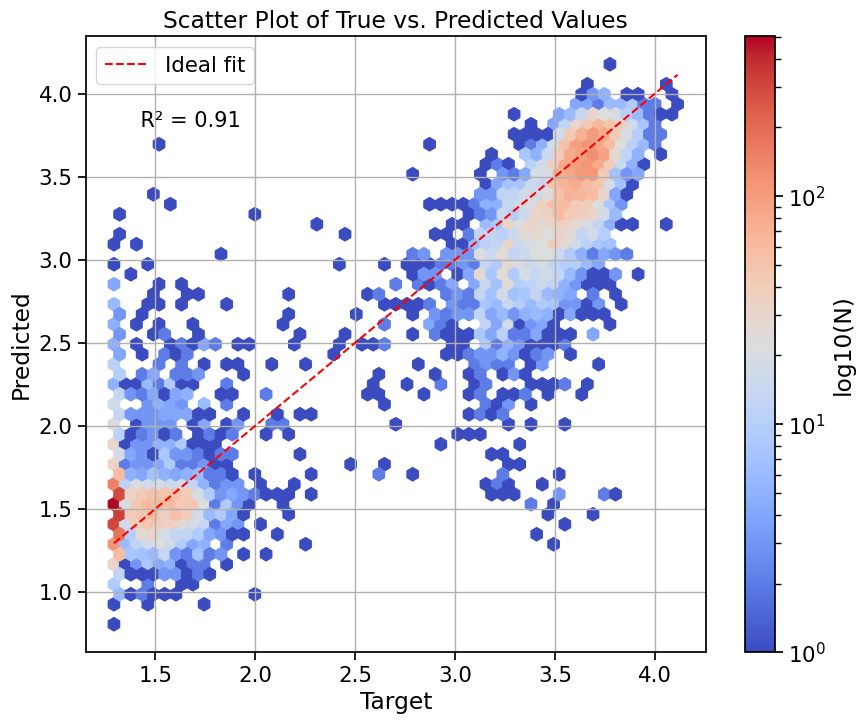

In [22]:
y_pred_ = y_test_pred.ravel()
y_true_ = y_test
# Calculate R-squared value
test_plot(y_true_,y_pred_)


# Select positions and predict all posible combintaions

In [23]:
df_selected = pd.read_csv('top_selected.csv')
df_selected

,Unnamed: 0,aaMutations,medianBrightness,aa_genotype_pseudo,full_seq
0,25644,K213N,3.508900,K221N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
1,34903,N104I:I170V,3.641843,N108I:I174V,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
2,23938,K157Q,3.675762,K161Q,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
3,25646,K213R,3.721051,K221R,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
4,23918,K157M,3.725150,K161M,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
5,34952,N104S,3.728561,N108S,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
6,52811,Y38C:I170N,3.729444,Y41C:I174N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATCGKLTLKF...
7,52963,Y38F,3.731584,Y41F,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATFGKLTLKF...
8,20927,I170V,3.733282,I174V,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
9,35028,N104S:K213R,3.734559,N108S:K221R,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...


In [24]:
selected_sequences = df_selected['full_seq'].values
blosum_encoded = sequence_to_blosum(selected_sequences,amino_acid_index, amino_acid_vectors)

In [25]:
X_top = blosum_encoded
y_top = df_selected['medianBrightness'].values.ravel()
y_top

array([3.50889953, 3.64184297, 3.67576205, 3.72105065, 3.72514962,
       3.72856098, 3.72944438, 3.7315839 , 3.73328177, 3.73455893,
       3.74690683, 3.75049579, 3.75487558, 3.75839337, 3.76378958,
       3.76565786, 3.76801822, 3.76934352, 3.76993627, 3.77115496,
       3.77275117, 3.77353417, 3.81332794, 3.82176873, 3.85394256,
       3.86298315, 3.87752331, 3.95633876, 4.05635983, 4.08598147,
       4.1135758 ])

In [26]:
y_top_pred = model.predict(X_top)
y_top_pred

1/1 [==============================] - 0s 72ms/step


array([[3.772009 ],
       [4.0002074],
       [3.78687  ],
       [3.7983189],
       [3.772068 ],
       [3.845945 ],
       [3.9325137],
       [3.7872849],
       [3.934801 ],
       [3.8092394],
       [3.8062177],
       [3.8521962],
       [3.8233633],
       [3.9177084],
       [3.91437  ],
       [3.8904653],
       [3.7939224],
       [3.8342838],
       [3.9613204],
       [4.090107 ],
       [3.8936987],
       [3.8966455],
       [3.9004312],
       [3.9638114],
       [3.8992672],
       [3.9647794],
       [3.884985 ],
       [3.8840852],
       [4.047463 ],
       [4.0301857],
       [3.763    ]], dtype=float32)

In [27]:
df_selected['fitness'] = y_top_pred.ravel()
df_selected

,Unnamed: 0,aaMutations,medianBrightness,aa_genotype_pseudo,full_seq,fitness
0,25644,K213N,3.508900,K221N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.772009
1,34903,N104I:I170V,3.641843,N108I:I174V,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,4.000207
2,23938,K157Q,3.675762,K161Q,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.786870
3,25646,K213R,3.721051,K221R,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.798319
4,23918,K157M,3.725150,K161M,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.772068
5,34952,N104S,3.728561,N108S,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.845945
6,52811,Y38C:I170N,3.729444,Y41C:I174N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATCGKLTLKF...,3.932514
7,52963,Y38F,3.731584,Y41F,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATFGKLTLKF...,3.787285
8,20927,I170V,3.733282,I174V,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.934801
9,35028,N104S:K213R,3.734559,N108S:K221R,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.809239


In [28]:
df_selected_pred = pd.read_csv('top_predicted.csv')
df_selected_pred

,Unnamed: 0,aaMutations,full_seq
0,0,Y38C,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATCGKLTLKF...
1,1,Y38F,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATFGKLTLKF...
2,2,Y38H,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATHGKLTLKF...
3,3,Y38N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...
4,4,N104I,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
...,...,...,...
3494,3494,Y38N:N104Y:K157V:I170T:K213N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...
3495,3495,Y38N:N104Y:K157V:I170T:K213R,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...
3496,3496,Y38N:N104Y:K157V:I170V:K213E,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...
3497,3497,Y38N:N104Y:K157V:I170V:K213N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...


In [29]:
selected_sequences = df_selected_pred['full_seq'].values
blosum_encoded = sequence_to_blosum(selected_sequences,amino_acid_index, amino_acid_vectors)

X_top = blosum_encoded

y_top_pred = model.predict(X_top)
y_top_pred

df_selected_pred['fitness'] = y_top_pred.ravel()
df_selected_pred

110/110 [==============================] - 0s 2ms/step


,Unnamed: 0,aaMutations,full_seq,fitness
0,0,Y38C,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATCGKLTLKF...,3.961320
1,1,Y38F,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATFGKLTLKF...,3.787285
2,2,Y38H,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATHGKLTLKF...,3.914370
3,3,Y38N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,3.964779
4,4,N104I,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.900431
...,...,...,...,...
3494,3494,Y38N:N104Y:K157V:I170T:K213N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.141232
3495,3495,Y38N:N104Y:K157V:I170T:K213R,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.167542
3496,3496,Y38N:N104Y:K157V:I170V:K213E,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.230742
3497,3497,Y38N:N104Y:K157V:I170V:K213N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.179388


In [30]:
merged = pd.merge( df_selected_pred,df_selected, on ='full_seq', how='left')
merged

,Unnamed: 0_x,aaMutations_x,full_seq,fitness_x,Unnamed: 0_y,aaMutations_y,medianBrightness,aa_genotype_pseudo,fitness_y
0,0,Y38C,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATCGKLTLKF...,3.961320,52747.0,Y38C,3.769936,Y41C,3.961320
1,1,Y38F,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATFGKLTLKF...,3.787285,52963.0,Y38F,3.731584,Y41F,3.787285
2,2,Y38H,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATHGKLTLKF...,3.914370,53047.0,Y38H,3.763790,Y41H,3.914370
3,3,Y38N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,3.964779,53247.0,Y38N,3.862983,Y41N,3.964779
4,4,N104I,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.900431,34885.0,N104I,3.813328,N108I,3.900431
...,...,...,...,...,...,...,...,...,...
3494,3494,Y38N:N104Y:K157V:I170T:K213N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.141232,NaN,NaN,NaN,NaN,NaN
3495,3495,Y38N:N104Y:K157V:I170T:K213R,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.167542,NaN,NaN,NaN,NaN,NaN
3496,3496,Y38N:N104Y:K157V:I170V:K213E,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.230742,NaN,NaN,NaN,NaN,NaN
3497,3497,Y38N:N104Y:K157V:I170V:K213N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.179388,NaN,NaN,NaN,NaN,NaN


In [31]:
merged['Fitness'] = merged['fitness_x']
merged

,Unnamed: 0_x,aaMutations_x,full_seq,fitness_x,Unnamed: 0_y,aaMutations_y,medianBrightness,aa_genotype_pseudo,fitness_y,Fitness
0,0,Y38C,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATCGKLTLKF...,3.961320,52747.0,Y38C,3.769936,Y41C,3.961320,3.961320
1,1,Y38F,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATFGKLTLKF...,3.787285,52963.0,Y38F,3.731584,Y41F,3.787285,3.787285
2,2,Y38H,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATHGKLTLKF...,3.914370,53047.0,Y38H,3.763790,Y41H,3.914370,3.914370
3,3,Y38N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,3.964779,53247.0,Y38N,3.862983,Y41N,3.964779,3.964779
4,4,N104I,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.900431,34885.0,N104I,3.813328,N108I,3.900431,3.900431
...,...,...,...,...,...,...,...,...,...,...
3494,3494,Y38N:N104Y:K157V:I170T:K213N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.141232,NaN,NaN,NaN,NaN,NaN,4.141232
3495,3495,Y38N:N104Y:K157V:I170T:K213R,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.167542,NaN,NaN,NaN,NaN,NaN,4.167542
3496,3496,Y38N:N104Y:K157V:I170V:K213E,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.230742,NaN,NaN,NaN,NaN,NaN,4.230742
3497,3497,Y38N:N104Y:K157V:I170V:K213N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.179388,NaN,NaN,NaN,NaN,NaN,4.179388


In [32]:
merged

,Unnamed: 0_x,aaMutations_x,full_seq,fitness_x,Unnamed: 0_y,aaMutations_y,medianBrightness,aa_genotype_pseudo,fitness_y,Fitness
0,0,Y38C,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATCGKLTLKF...,3.961320,52747.0,Y38C,3.769936,Y41C,3.961320,3.961320
1,1,Y38F,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATFGKLTLKF...,3.787285,52963.0,Y38F,3.731584,Y41F,3.787285,3.787285
2,2,Y38H,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATHGKLTLKF...,3.914370,53047.0,Y38H,3.763790,Y41H,3.914370,3.914370
3,3,Y38N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,3.964779,53247.0,Y38N,3.862983,Y41N,3.964779,3.964779
4,4,N104I,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.900431,34885.0,N104I,3.813328,N108I,3.900431,3.900431
...,...,...,...,...,...,...,...,...,...,...
3494,3494,Y38N:N104Y:K157V:I170T:K213N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.141232,NaN,NaN,NaN,NaN,NaN,4.141232
3495,3495,Y38N:N104Y:K157V:I170T:K213R,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.167542,NaN,NaN,NaN,NaN,NaN,4.167542
3496,3496,Y38N:N104Y:K157V:I170V:K213E,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.230742,NaN,NaN,NaN,NaN,NaN,4.230742
3497,3497,Y38N:N104Y:K157V:I170V:K213N,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATNGKLTLKF...,4.179388,NaN,NaN,NaN,NaN,NaN,4.179388


In [36]:
import pandas as pd
import plotly.express as px
# Determine the color based on the count of ':' in 'aaMutations'
merged['color'] = merged['aaMutations_x'].apply(lambda x: 
    '#DC143C' if x.count(':') == 0 else
    '#DC143C' if x.count(':') == 1 else
    '#47c826' if x.count(':') == 2 else
    '#95a7ef' if x.count(':') == 3 else
    '#95a7ef' if x.count(':') == 4 else
    '#143cdc'  # For any other higher counts
)


df = merged
# Create the figure
fig = go.Figure()
jitter = np.random.uniform(0, 0.5, size=len(df))
# Add a scatter trace
fig.add_trace(go.Scatter(
    x=jitter,  # X-axis labels (all the same, resulting in one vertical line of points)
    y=df['Fitness'],
    mode='markers',
    text=df['aaMutations_x'],  # Hover text
    hoverinfo='text+y',
    marker=dict(
        color=df['color'],  # Use the color column for marker colors
        # size=6,  # Adjust marker size  # Marker border
    ),
    showlegend=True
))

# Update layout
fig.update_layout(title='Fitness Stripplot',
                  yaxis_title='Predicted brightness',
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  
                    height=800,  # Set the height of the plot
                    width=800,
                  plot_bgcolor='white')
# Show the plot
fig.show()

In [43]:
merged.to_csv('predictions_blosumH5.csv')

In [38]:
from plotly.subplots import make_subplots

merged['category'] = merged['aaMutations_x'].apply(lambda x: x.count(':'))

# Determine the number of categories (plus one for any counts above 4)
max_category = int(merged['category'].max())

# Setup subplots
fig = make_subplots(rows=1, cols=max_category+1, shared_yaxes=True, subplot_titles=[f"{i+1} Mutation(s)" for i in range(max_category+1)])

# Add jitter and plot data for each category
for i in range(max_category+1):
    # Filter data for each category
    df_filtered = merged[merged['category'] == i]
    jitter = np.random.uniform(-0.2, 0.2, size=len(df_filtered)) + i  # Jitter and shift to align vertically on subplots
    
    fig.add_trace(
        go.Scatter(
            x=jitter,
            y=df_filtered['Fitness'],
            mode='markers',
            name=f" {i+1} Mutation(s)",
            marker=dict(size=6),
            text=df_filtered['aaMutations_x'],  # Hover text
            hoverinfo='text+y'
        ),
        row=1, col=i+1
    )

# Update layout
fig.update_layout(
    title='Fitness Stripplot by Mutation Count',
    yaxis_title='Predicted Brightness',
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    height=800,
    width=1200 * (max_category + 1) / 5,  # Adjust width based on the number of subplots
    plot_bgcolor='white',
    showlegend=False,
       font=dict(
        size=16,  # Specify a default font size
    )
)
fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False)

# Show the plot
fig.show()

In [41]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Example DataFrame creation
df = merged

# Create a jitter function
def jitter(n, width=0.2):
    return np.random.uniform(-width, width, size=n)

# Filter rows where 'medianBrightness' is available
df_with_brightness = df.dropna(subset=['medianBrightness'])

# Create x-coordinates for the points with jitter
x_fitness_only_jitter = [1 + j for j in jitter(len(df[df['medianBrightness'].isna()]))]
x_median_brightness_jitter = [2 + j for j in jitter(len(df_with_brightness))]
x_fitness_with_brightness_jitter = [3 + j for j in jitter(len(df_with_brightness))]

# Create a Plotly graph object figure
fig = go.Figure()

# Define x-axis positions (columns) for each group
x_positions = [1, 2, 3]
x_labels = ['Predicted variants - prediction', 'Training variants - measure' , 'Training variants - prediction']

# Add Fitness values where 'medianBrightness' is not available (in blue)
for i, (x, fitness, mutation) in enumerate(zip(x_fitness_only_jitter, df[df['medianBrightness'].isna()]['Fitness'], df[df['medianBrightness'].isna()]['aaMutations_x'])):
    fig.add_trace(go.Scatter(
        x=[x],
        y=[fitness],
        mode='markers',
        marker=dict(color='#179bff', size=8),
        text=[mutation],  # Hover text
        
    height=600,  # Set the height of the plot
    width=1000,
        legendgroup='fitness_only',
        showlegend=False
    ))

# Add 'medianBrightness' values (in red)
for i, (x, mb, mutation) in enumerate(zip(x_median_brightness_jitter, df_with_brightness['medianBrightness'], df_with_brightness['aaMutations_x'])):
    fig.add_trace(go.Scatter(
        x=[x],
        y=[mb],
        mode='markers',
        marker=dict(color='#ff3237', size=8),
        text=[mutation],
        hoverinfo='text+y',
        legendgroup='median_brightness',
        showlegend=False
    ))

# Add Fitness values corresponding to 'medianBrightness' values (in green)
for i, (x, fitness, mutation) in enumerate(zip(x_fitness_with_brightness_jitter, df_with_brightness['Fitness'], df_with_brightness['aaMutations_x'])):
    fig.add_trace(go.Scatter(
        x=[x],
        y=[fitness],
        mode='markers',
        marker=dict(color='#2ccc28', size=8),
        text=[mutation],
        hoverinfo='text+y',
        legendgroup='fitness_with_brightness',
        showlegend=False
    ))

# Add lines connecting red and green dots correctly
for red_x, green_x, mb, fitness, mutation in zip(x_median_brightness_jitter, x_fitness_with_brightness_jitter, df_with_brightness['medianBrightness'], df_with_brightness['Fitness'], df_with_brightness['aaMutations_x']):
    fig.add_trace(go.Scatter(
        x=[red_x, green_x],
        y=[mb, fitness],
        mode='lines',
        line=dict(color='gray', width=1),
        hoverinfo='skip',
        legendgroup='lines',
        showlegend=False
    ))

# Update layout for a taller plot, add borders, remove the legend, and set x-axis labels
fig.update_layout(
    title="",
    xaxis=dict(
        tickvals=x_positions,
        ticktext=x_labels,
        showgrid=False,
        showticklabels=True,
        zeroline=False,
        showline=True,
        linewidth=2,
        linecolor='black'
    ),
    yaxis=dict(
        zeroline=False,
        showline=True,
        linewidth=2,
        linecolor='black'
    ),
    font=dict(
        size=16,  # Set the font size here
    ),
    yaxis_title="Brightness",
    plot_bgcolor='white',
    height=600,  # Set the height of the plot
    width=1000,
    margin=dict(l=20, r=20, t=30, b=20),  # Adjust margins to ensure borders are visible
    # paper_bgcolor="LightSteelBlue",  # Set background color of the paper (plot area)
    showlegend=False  # Hide the legend
)

# Show the figure
fig.show()
# fig.write_html(working_folder+"\stripplot_blosum.html")


ValueError: Invalid property specified for object of type plotly.graph_objs.Scatter: 'height'

Did you mean "text"?

    Valid properties:
        alignmentgroup
            Set several traces linked to the same position axis or
            matching axes to the same alignmentgroup. This controls
            whether bars compute their positional range dependently
            or independently.
        cliponaxis
            Determines whether or not markers and text nodes are
            clipped about the subplot axes. To show markers and
            text nodes above axis lines and tick labels, make sure
            to set `xaxis.layer` and `yaxis.layer` to *below
            traces*.
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the provided data arrays are connected.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            `customdata`.
        dx
            Sets the x coordinate step. See `x0` for more info.
        dy
            Sets the y coordinate step. See `y0` for more info.
        error_x
            :class:`plotly.graph_objects.scatter.ErrorX` instance
            or dict with compatible properties
        error_y
            :class:`plotly.graph_objects.scatter.ErrorY` instance
            or dict with compatible properties
        fill
            Sets the area to fill with a solid color. Defaults to
            "none" unless this trace is stacked, then it gets
            "tonexty" ("tonextx") if `orientation` is "v" ("h") Use
            with `fillcolor` if not "none". "tozerox" and "tozeroy"
            fill to x=0 and y=0 respectively. "tonextx" and
            "tonexty" fill between the endpoints of this trace and
            the endpoints of the trace before it, connecting those
            endpoints with straight lines (to make a stacked area
            graph); if there is no trace before it, they behave
            like "tozerox" and "tozeroy". "toself" connects the
            endpoints of the trace (or each segment of the trace if
            it has gaps) into a closed shape. "tonext" fills the
            space between two traces if one completely encloses the
            other (eg consecutive contour lines), and behaves like
            "toself" if there is no trace before it. "tonext"
            should not be used if one trace does not enclose the
            other. Traces in a `stackgroup` will only fill to (or
            be filled to) other traces in the same group. With
            multiple `stackgroup`s or some traces stacked and some
            not, if fill-linked traces are not already consecutive,
            the later ones will be pushed down in the drawing
            order.
        fillcolor
            Sets the fill color. Defaults to a half-transparent
            variant of the line color, marker color, or marker line
            color, whichever is available.
        fillpattern
            Sets the pattern within the marker.
        groupnorm
            Only relevant when `stackgroup` is used, and only the
            first `groupnorm` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Sets the normalization for the sum of
            this `stackgroup`. With "fraction", the value of each
            trace at each location is divided by the sum of all
            trace values at that location. "percent" is the same
            but multiplied by 100 to show percentages. If there are
            multiple subplots, or multiple `stackgroup`s on one
            subplot, each will be normalized within its own set.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            `hoverinfo`.
        hoverlabel
            :class:`plotly.graph_objects.scatter.Hoverlabel`
            instance or dict with compatible properties
        hoveron
            Do the hover effects highlight individual points
            (markers or line points) or do they highlight filled
            regions? If the fill is "toself" or "tonext" and there
            are no markers or text, then the default is "fills",
            otherwise it is "points".
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}" as well as %{xother}, {%_xother},
            {%_xother_}, {%xother_}. When showing info for several
            points, "xother" will be added to those with different
            x positions from the first point. An underscore before
            or after "(x|y)other" will add a space on that side,
            only when this field is shown. Numbers are formatted
            using d3-format's syntax %{variable:d3-format}, for
            example "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. The variables available in
            `hovertemplate` are the ones emitted as event data
            described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `hovertemplate`.
        hovertext
            Sets hover text elements associated with each (x,y)
            pair. If a single string, the same string appears over
            all the data points. If an array of string, the items
            are mapped in order to the this trace's (x,y)
            coordinates. To be seen, trace `hoverinfo` must contain
            a "text" flag.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            `hovertext`.
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            `ids`.
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        legendgrouptitle
            :class:`plotly.graph_objects.scatter.Legendgrouptitle`
            instance or dict with compatible properties
        legendrank
            Sets the legend rank for this trace. Items and groups
            with smaller ranks are presented on top/left side while
            with `*reversed* `legend.traceorder` they are on
            bottom/right side. The default legendrank is 1000, so
            that you can use ranks less than 1000 to place certain
            items before all unranked items, and ranks greater than
            1000 to go after all unranked items.
        legendwidth
            Sets the width (in px or fraction) of the legend for
            this trace.
        line
            :class:`plotly.graph_objects.scatter.Line` instance or
            dict with compatible properties
        marker
            :class:`plotly.graph_objects.scatter.Marker` instance
            or dict with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        mode
            Determines the drawing mode for this scatter trace. If
            the provided `mode` includes "text" then the `text`
            elements appear at the coordinates. Otherwise, the
            `text` elements appear on hover. If there are less than
            20 points and the trace is not stacked then the default
            is "lines+markers". Otherwise, "lines".
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        offsetgroup
            Set several traces linked to the same position axis or
            matching axes to the same offsetgroup where bars of the
            same position coordinate will line up.
        opacity
            Sets the opacity of the trace.
        orientation
            Only relevant in the following cases: 1. when
            `scattermode` is set to "group". 2. when `stackgroup`
            is used, and only the first `orientation` found in the
            `stackgroup` will be used - including if `visible` is
            "legendonly" but not if it is `false`. Sets the
            stacking direction. With "v" ("h"), the y (x) values of
            subsequent traces are added. Also affects the default
            value of `fill`.
        selected
            :class:`plotly.graph_objects.scatter.Selected` instance
            or dict with compatible properties
        selectedpoints
            Array containing integer indices of selected points.
            Has an effect only for traces that support selections.
            Note that an empty array means an empty selection where
            the `unselected` are turned on for all points, whereas,
            any other non-array values means no selection all where
            the `selected` and `unselected` styles have no effect.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        stackgaps
            Only relevant when `stackgroup` is used, and only the
            first `stackgaps` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Determines how we handle locations at
            which other traces in this group have data but this one
            does not. With *infer zero* we insert a zero at these
            locations. With "interpolate" we linearly interpolate
            between existing values, and extrapolate a constant
            beyond the existing values.
        stackgroup
            Set several scatter traces (on the same subplot) to the
            same stackgroup in order to add their y values (or
            their x values if `orientation` is "h"). If blank or
            omitted this trace will not be stacked. Stacking also
            turns `fill` on by default, using "tonexty" ("tonextx")
            if `orientation` is "h" ("v") and sets the default
            `mode` to "lines" irrespective of point count. You can
            only stack on a numeric (linear or log) axis. Traces in
            a `stackgroup` will only fill to (or be filled to)
            other traces in the same group. With multiple
            `stackgroup`s or some traces stacked and some not, if
            fill-linked traces are not already consecutive, the
            later ones will be pushed down in the drawing order.
        stream
            :class:`plotly.graph_objects.scatter.Stream` instance
            or dict with compatible properties
        text
            Sets text elements associated with each (x,y) pair. If
            a single string, the same string appears over all the
            data points. If an array of string, the items are
            mapped in order to the this trace's (x,y) coordinates.
            If trace `hoverinfo` contains a "text" flag and
            "hovertext" is not set, these elements will be seen in
            the hover labels.
        textfont
            Sets the text font.
        textposition
            Sets the positions of the `text` elements with respects
            to the (x,y) coordinates.
        textpositionsrc
            Sets the source reference on Chart Studio Cloud for
            `textposition`.
        textsrc
            Sets the source reference on Chart Studio Cloud for
            `text`.
        texttemplate
            Template string used for rendering the information text
            that appear on points. Note that this will override
            `textinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. Every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.
        texttemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `texttemplate`.
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        unselected
            :class:`plotly.graph_objects.scatter.Unselected`
            instance or dict with compatible properties
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x
            Sets the x coordinates.
        x0
            Alternate to `x`. Builds a linear space of x
            coordinates. Use with `dx` where `x0` is the starting
            coordinate and `dx` the step.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xhoverformat
            Sets the hover text formatting rulefor `x`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `xaxis.hoverformat`.
        xperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the x
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        xperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the x0 axis. When `x0period` is round number
            of weeks, the `x0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        xperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the x axis.
        xsrc
            Sets the source reference on Chart Studio Cloud for
            `x`.
        y
            Sets the y coordinates.
        y0
            Alternate to `y`. Builds a linear space of y
            coordinates. Use with `dy` where `y0` is the starting
            coordinate and `dy` the step.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        ycalendar
            Sets the calendar system to use with `y` date data.
        yhoverformat
            Sets the hover text formatting rulefor `y`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `yaxis.hoverformat`.
        yperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the y
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        yperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the y0 axis. When `y0period` is round number
            of weeks, the `y0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        yperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the y axis.
        ysrc
            Sets the source reference on Chart Studio Cloud for
            `y`.
        
Did you mean "text"?

Bad property path:
height
^^^^^^

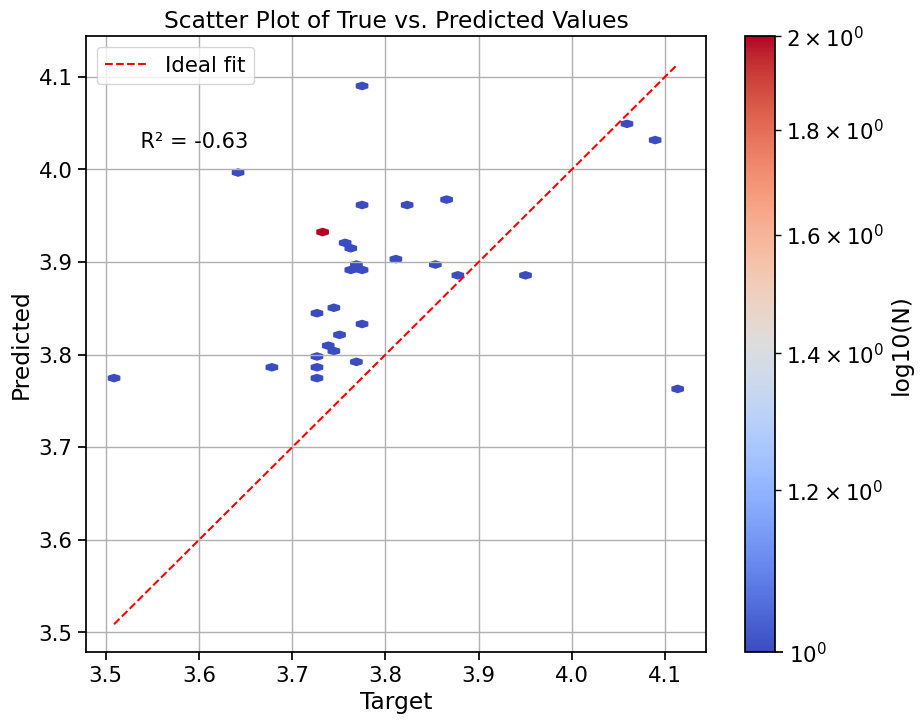

In [40]:
y_pred_ = df_selected['fitness'].values
y_true_ = df_selected[brightness_col].values
# Calculate R-squared value
test_plot(y_true_,y_pred_)